# Tarea 1
### Francisco Javier Villarroel Herrera

In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import sklearn
import scipy 
from scipy.stats import nbinom
from statsmodels.iolib.summary2 import summary_col

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

Las variables tienen la siguiente descripcion:

- Date: data medida en frecuencia diaria
- Location: ubicacion del medidor
- Min_Temp: temperatura minima observada
- Max_Temp: temperatura maxima observada
- Leakage: Filtracion medida en el area
- Evaporation: Tasa de evaporacion
- Electricity: Consumo electrico KW
- Parameter#: Diferentes sensores de reportando direccion y velocidad de viento en distintos momentos del dia, asi como otras metricas relevantes.
- Failure today: El sensor reporta fallo (o no)

## 1. Análisis exploratorio, tipos de datos y limpieza

Se comienza cargando la base de datos machine_failure_data.csv y se transforma la variable Date a formato de fecha. Además, se restringe el análisis a datos posteriores al año 2008, para asegurar consistencia temporal.

La variable dependiente Failure_today se recodifica a valores binarios (1 para "Yes" y 0 para "No"), facilitando su uso en modelos de regresión. La variable Leakage se transforma a logaritmo (con un pequeño ajuste de +0.1 para evitar problemas con ceros), con el objetivo de estabilizar su varianza y mejorar la interpretación.

Se eliminan variables con más de un 10% de datos faltantes (Evaporation, Electricity, y algunos Parameter5). Además, se descarta Parameter6 por falta de interpretabilidad clara. Finalmente, se eliminan las filas con valores faltantes restantes y se genera una variable estacional a partir del mes de la fecha para capturar efectos temporales.

In [5]:
df = pd.read_csv('../../data/machine_failure_data.csv')
df

,Date,Location,Min_Temp,Max_Temp,Leakage,Evaporation,Electricity,Parameter1_Dir,Parameter1_Speed,Parameter2_9am,...,Parameter3_3pm,Parameter4_9am,Parameter4_3pm,Parameter5_9am,Parameter5_3pm,Parameter6_9am,Parameter6_3pm,Parameter7_9am,Parameter7_3pm,Failure_today
0,12/1/2008,3,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,24.0,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No
1,12/2/2008,3,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,22.0,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No
2,12/3/2008,3,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,26.0,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No
3,12/4/2008,3,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,9.0,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No
4,12/5/2008,3,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142188,6/20/2017,42,3.5,21.8,0.0,NaN,NaN,E,31.0,ESE,...,13.0,59.0,27.0,1024.7,1021.2,NaN,NaN,9.4,20.9,No
142189,6/21/2017,42,2.8,23.4,0.0,NaN,NaN,E,31.0,SE,...,11.0,51.0,24.0,1024.6,1020.3,NaN,NaN,10.1,22.4,No
142190,6/22/2017,42,3.6,25.3,0.0,NaN,NaN,NNW,22.0,SE,...,9.0,56.0,21.0,1023.5,1019.1,NaN,NaN,10.9,24.5,No
142191,6/23/2017,42,5.4,26.9,0.0,NaN,NaN,N,37.0,SE,...,9.0,53.0,24.0,1021.0,1016.8,NaN,NaN,12.5,26.1,No


In [6]:
#Cambiamos el formato de la fecha, y empezamos desde el 2009
df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%Y')
df = df[df['Date'].dt.year > 2008]

#La variable dependiente se pasa a 0 y 1.
df['Failure_today'] = df['Failure_today'].replace(["Yes", "No"],[1,0])

#Leakage se transforma a logaritmo
df['Leakage_log'] = np.log(df['Leakage']+0.1)

#El parámetro 6 no es de interes, al no poderse interpretar.
df = df.drop(['Parameter6_9am','Parameter6_3pm'], axis=1)
df

,Date,Location,Min_Temp,Max_Temp,Leakage,Evaporation,Electricity,Parameter1_Dir,Parameter1_Speed,Parameter2_9am,...,Parameter3_9am,Parameter3_3pm,Parameter4_9am,Parameter4_3pm,Parameter5_9am,Parameter5_3pm,Parameter7_9am,Parameter7_3pm,Failure_today,Leakage_log
30,2009-01-01,3,11.3,26.5,0.0,NaN,NaN,WNW,56.0,W,...,19.0,31.0,46.0,26.0,1004.5,1003.2,19.7,25.7,0.0,-2.302585
31,2009-01-02,3,9.6,23.9,0.0,NaN,NaN,W,41.0,WSW,...,19.0,11.0,44.0,22.0,1014.4,1013.1,14.9,22.1,0.0,-2.302585
32,2009-01-03,3,10.5,28.8,0.0,NaN,NaN,SSE,26.0,SSE,...,11.0,7.0,43.0,22.0,1018.7,1014.8,17.1,26.5,0.0,-2.302585
33,2009-01-04,3,12.3,34.6,0.0,NaN,NaN,WNW,37.0,SSE,...,6.0,17.0,41.0,12.0,1015.1,1010.3,20.7,33.9,0.0,-2.302585
34,2009-01-05,3,12.9,35.8,0.0,NaN,NaN,WNW,41.0,ENE,...,6.0,26.0,41.0,9.0,1012.6,1009.2,22.4,34.4,0.0,-2.302585
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142188,2017-06-20,42,3.5,21.8,0.0,NaN,NaN,E,31.0,ESE,...,15.0,13.0,59.0,27.0,1024.7,1021.2,9.4,20.9,0.0,-2.302585
142189,2017-06-21,42,2.8,23.4,0.0,NaN,NaN,E,31.0,SE,...,13.0,11.0,51.0,24.0,1024.6,1020.3,10.1,22.4,0.0,-2.302585
142190,2017-06-22,42,3.6,25.3,0.0,NaN,NaN,NNW,22.0,SE,...,13.0,9.0,56.0,21.0,1023.5,1019.1,10.9,24.5,0.0,-2.302585
142191,2017-06-23,42,5.4,26.9,0.0,NaN,NaN,N,37.0,SE,...,9.0,9.0,53.0,24.0,1021.0,1016.8,12.5,26.1,0.0,-2.302585


In [7]:
#Cambio formato fecha

# Crear una función para asignar estaciones
def obtener_estacion(fecha):
    mes = fecha.month
    if mes in [12, 1, 2]:
        return 1 #Invierno
    elif mes in [3, 4, 5]:
        return 2 #Primavera
    elif mes in [6, 7, 8]:
        return 3 #Verano
    else:
        return 4 #Otoño

# Aplicar la función
df['Season'] = df['Date'].apply(obtener_estacion)
df

,Date,Location,Min_Temp,Max_Temp,Leakage,Evaporation,Electricity,Parameter1_Dir,Parameter1_Speed,Parameter2_9am,...,Parameter3_3pm,Parameter4_9am,Parameter4_3pm,Parameter5_9am,Parameter5_3pm,Parameter7_9am,Parameter7_3pm,Failure_today,Leakage_log,Season
30,2009-01-01,3,11.3,26.5,0.0,NaN,NaN,WNW,56.0,W,...,31.0,46.0,26.0,1004.5,1003.2,19.7,25.7,0.0,-2.302585,1
31,2009-01-02,3,9.6,23.9,0.0,NaN,NaN,W,41.0,WSW,...,11.0,44.0,22.0,1014.4,1013.1,14.9,22.1,0.0,-2.302585,1
32,2009-01-03,3,10.5,28.8,0.0,NaN,NaN,SSE,26.0,SSE,...,7.0,43.0,22.0,1018.7,1014.8,17.1,26.5,0.0,-2.302585,1
33,2009-01-04,3,12.3,34.6,0.0,NaN,NaN,WNW,37.0,SSE,...,17.0,41.0,12.0,1015.1,1010.3,20.7,33.9,0.0,-2.302585,1
34,2009-01-05,3,12.9,35.8,0.0,NaN,NaN,WNW,41.0,ENE,...,26.0,41.0,9.0,1012.6,1009.2,22.4,34.4,0.0,-2.302585,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142188,2017-06-20,42,3.5,21.8,0.0,NaN,NaN,E,31.0,ESE,...,13.0,59.0,27.0,1024.7,1021.2,9.4,20.9,0.0,-2.302585,3
142189,2017-06-21,42,2.8,23.4,0.0,NaN,NaN,E,31.0,SE,...,11.0,51.0,24.0,1024.6,1020.3,10.1,22.4,0.0,-2.302585,3
142190,2017-06-22,42,3.6,25.3,0.0,NaN,NaN,NNW,22.0,SE,...,9.0,56.0,21.0,1023.5,1019.1,10.9,24.5,0.0,-2.302585,3
142191,2017-06-23,42,5.4,26.9,0.0,NaN,NaN,N,37.0,SE,...,9.0,53.0,24.0,1021.0,1016.8,12.5,26.1,0.0,-2.302585,3


In [8]:
#Falta más del 10% de estas variables: Evaporation, Electricity,Parameter5
df = df.drop(['Evaporation', 'Electricity','Parameter5_9am','Parameter5_3pm'], axis=1)

#Luego se limpian los pocos NaN que van quedando
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)
df

,Date,Location,Min_Temp,Max_Temp,Leakage,Parameter1_Dir,Parameter1_Speed,Parameter2_9am,Parameter2_3pm,Parameter3_9am,Parameter3_3pm,Parameter4_9am,Parameter4_3pm,Parameter7_9am,Parameter7_3pm,Failure_today,Leakage_log,Season
0,2009-01-01,3,11.3,26.5,0.0,WNW,56.0,W,WNW,19.0,31.0,46.0,26.0,19.7,25.7,0.0,-2.302585,1
1,2009-01-02,3,9.6,23.9,0.0,W,41.0,WSW,SSW,19.0,11.0,44.0,22.0,14.9,22.1,0.0,-2.302585,1
2,2009-01-03,3,10.5,28.8,0.0,SSE,26.0,SSE,E,11.0,7.0,43.0,22.0,17.1,26.5,0.0,-2.302585,1
3,2009-01-04,3,12.3,34.6,0.0,WNW,37.0,SSE,NW,6.0,17.0,41.0,12.0,20.7,33.9,0.0,-2.302585,1
4,2009-01-05,3,12.9,35.8,0.0,WNW,41.0,ENE,NW,6.0,26.0,41.0,9.0,22.4,34.4,0.0,-2.302585,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120011,2017-06-20,42,3.5,21.8,0.0,E,31.0,ESE,E,15.0,13.0,59.0,27.0,9.4,20.9,0.0,-2.302585,3
120012,2017-06-21,42,2.8,23.4,0.0,E,31.0,SE,ENE,13.0,11.0,51.0,24.0,10.1,22.4,0.0,-2.302585,3
120013,2017-06-22,42,3.6,25.3,0.0,NNW,22.0,SE,N,13.0,9.0,56.0,21.0,10.9,24.5,0.0,-2.302585,3
120014,2017-06-23,42,5.4,26.9,0.0,N,37.0,SE,WNW,9.0,9.0,53.0,24.0,12.5,26.1,0.0,-2.302585,3


In [9]:
df.dtypes

Date                datetime64[ns]
Location                     int64
Min_Temp                   float64
Max_Temp                   float64
Leakage                    float64
Parameter1_Dir              object
Parameter1_Speed           float64
Parameter2_9am              object
Parameter2_3pm              object
Parameter3_9am             float64
Parameter3_3pm             float64
Parameter4_9am             float64
Parameter4_3pm             float64
Parameter7_9am             float64
Parameter7_3pm             float64
Failure_today              float64
Leakage_log                float64
Season                       int64
dtype: object

In [10]:
df.describe()

,Date,Location,Min_Temp,Max_Temp,Leakage,Parameter1_Speed,Parameter3_9am,Parameter3_3pm,Parameter4_9am,Parameter4_3pm,Parameter7_9am,Parameter7_3pm,Failure_today,Leakage_log,Season
count,120016,120016.000000,120016.000000,120016.000000,120016.000000,120016.000000,120016.000000,120016.000000,120016.000000,120016.000000,120016.000000,120016.000000,120016.000000,120016.000000,120016.000000
mean,2013-05-07 09:01:51.585122304,25.421494,12.391379,23.443086,2.357949,40.668528,15.041653,19.201648,67.742018,50.854436,17.219990,21.914747,0.223745,-1.186474,2.494059
min,2009-01-01 00:00:00,1.000000,-8.500000,-4.800000,0.000000,7.000000,2.000000,2.000000,0.000000,0.000000,-7.200000,-5.400000,0.000000,-2.302585,1.000000
25%,2011-02-26 00:00:00,13.000000,7.800000,18.100000,0.000000,31.000000,9.000000,13.000000,56.000000,36.000000,12.500000,16.800000,0.000000,-2.302585,2.000000
50%,2013-07-06 00:00:00,26.000000,12.200000,23.000000,0.000000,39.000000,13.000000,19.000000,69.000000,51.000000,16.900000,21.400000,0.000000,-2.302585,2.000000
75%,2015-06-29 00:00:00,38.000000,17.000000,28.500000,0.800000,48.000000,20.000000,24.000000,82.000000,65.000000,21.800000,26.800000,0.000000,-0.105361,4.000000
max,2017-06-25 00:00:00,49.000000,33.900000,48.100000,367.600000,135.000000,87.000000,87.000000,100.000000,100.000000,40.200000,46.700000,1.000000,5.907267,4.000000
std,NaN,14.114414,6.329952,7.145401,8.502443,13.388251,8.318630,8.590975,19.090525,20.972111,6.449757,7.010703,0.416755,1.742637,1.117069


In [11]:
df['Parameter1_Dir'].value_counts()

Parameter1_Dir
W      8930
SE     8590
SSE    8292
S      8233
E      8155
WSW    8080
SW     8003
N      7986
SSW    7911
WNW    7204
ENE    7184
NW     7046
ESE    6547
NE     6331
NNE    5784
NNW    5740
Name: count, dtype: int64

In [12]:
df['Parameter2_9am'].value_counts()

Parameter2_9am
N      10406
SSE     8460
E       8331
SE      8130
S       7874
SW      7445
NNE     7397
W       7213
ENE     7209
NW      7122
NNW     7067
ESE     6955
SSW     6878
NE      6767
WNW     6491
WSW     6271
Name: count, dtype: int64

In [13]:
df['Parameter2_3pm'].value_counts()

Parameter2_3pm
SE     8717
W      8683
S      8575
SSE    8249
WSW    8156
SW     7979
WNW    7600
N      7576
ESE    7217
SSW    7142
E      7097
NW     6963
NE     6961
ENE    6871
NNW    6578
NNE    5652
Name: count, dtype: int64

In [14]:
direccion_simplificada = {
    'N': 'N', 'NNE': 'N', 'NNW': 'N', 'NE': 'N', 'NW': 'N',
    'S': 'S', 'SSE': 'S', 'SSW': 'S', 'SE': 'S', 'SW': 'S',
    'E': 'E', 'ENE': 'E', 'ESE': 'E',
    'W': 'W', 'WNW': 'W', 'WSW': 'W'
}
df['Parameter1_Dir'] = df['Parameter1_Dir'].map(direccion_simplificada)
df['Parameter2_9am'] = df['Parameter2_9am'].map(direccion_simplificada)
df['Parameter2_3pm'] = df['Parameter2_3pm'].map(direccion_simplificada)
df

,Date,Location,Min_Temp,Max_Temp,Leakage,Parameter1_Dir,Parameter1_Speed,Parameter2_9am,Parameter2_3pm,Parameter3_9am,Parameter3_3pm,Parameter4_9am,Parameter4_3pm,Parameter7_9am,Parameter7_3pm,Failure_today,Leakage_log,Season
0,2009-01-01,3,11.3,26.5,0.0,W,56.0,W,W,19.0,31.0,46.0,26.0,19.7,25.7,0.0,-2.302585,1
1,2009-01-02,3,9.6,23.9,0.0,W,41.0,W,S,19.0,11.0,44.0,22.0,14.9,22.1,0.0,-2.302585,1
2,2009-01-03,3,10.5,28.8,0.0,S,26.0,S,E,11.0,7.0,43.0,22.0,17.1,26.5,0.0,-2.302585,1
3,2009-01-04,3,12.3,34.6,0.0,W,37.0,S,N,6.0,17.0,41.0,12.0,20.7,33.9,0.0,-2.302585,1
4,2009-01-05,3,12.9,35.8,0.0,W,41.0,E,N,6.0,26.0,41.0,9.0,22.4,34.4,0.0,-2.302585,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120011,2017-06-20,42,3.5,21.8,0.0,E,31.0,E,E,15.0,13.0,59.0,27.0,9.4,20.9,0.0,-2.302585,3
120012,2017-06-21,42,2.8,23.4,0.0,E,31.0,S,E,13.0,11.0,51.0,24.0,10.1,22.4,0.0,-2.302585,3
120013,2017-06-22,42,3.6,25.3,0.0,N,22.0,S,N,13.0,9.0,56.0,21.0,10.9,24.5,0.0,-2.302585,3
120014,2017-06-23,42,5.4,26.9,0.0,N,37.0,S,W,9.0,9.0,53.0,24.0,12.5,26.1,0.0,-2.302585,3


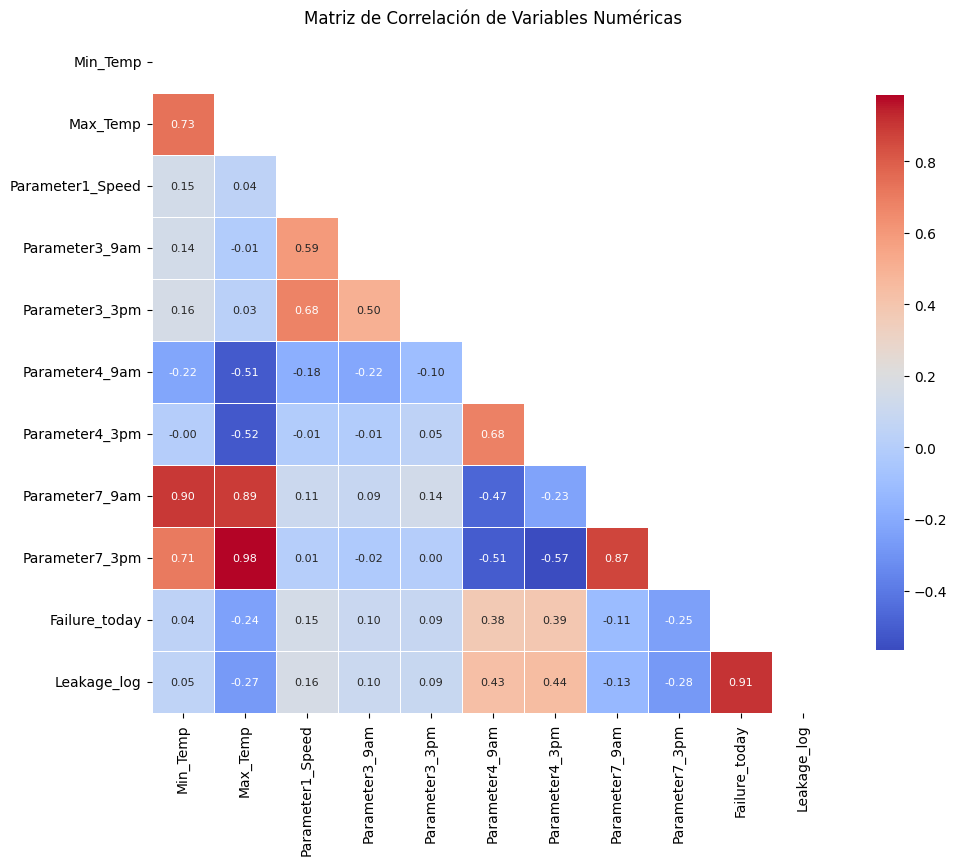

In [15]:
#Matriz de correlación

numeric_df = df.select_dtypes(include=['float64', 'int64'])
numeric_df = numeric_df.drop(['Location', 'Season','Leakage'], axis=1)

corr = numeric_df.corr()

# Crea la máscara para ocultar la mitad superior
mask = np.triu(np.ones_like(corr, dtype=bool))

# Establece tamaño del gráfico y el color
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Crea el heatmap
sns.heatmap(
    corr, annot=True, mask=mask, fmt=".2f", cmap='coolwarm', square=True, linewidths=0.5, annot_kws={'size': 8}, cbar_kws={"shrink": .8})
plt.title('Matriz de Correlación de Variables Numéricas')
plt.show()

Relaciones:
- Parameter1_Dir        Dirección del viento
- Parameter1_Speed      Velocidad del viento
- Parameter2_9am        Dirección del viento a las 9am
- Parameter2_3pm        Dirección del viento a las 3pm
- Parameter3_9am        Velocidad del viento a las 9am
- Parameter3_3pm        Velocidad del viento a las 3pm
- Parameter7_9am        Temperatura medida a las 9am
- Parameter7_3pm        Temperatura medida a las 3pm

In [16]:
df = df.drop(['Parameter7_9am','Parameter7_3pm','Leakage'], axis=1)

## 2. Modelo OLS

Se ejecuta un modelo de regresión lineal (OLS) donde la variable dependiente es Failure_today. Se seleccionan como regresores: Min_Temp, Max_Temp, variables de Parameter relacionadas con mediciones de los sensores (Parameter1, Parameter2, Parameter3, Parameter4), y la variable Season.

El Leakage_log fue analizado por separado, y se dejo finalmente de lado al estar demasiado correlacionada con la variable de estudio de probabilidad de fallas, que luego más adelante se descubriria que tiene predicción perfecta en los siguientes modelos. Por lo tanto, se dejo fuera del analisis de aquí en adelante.

El modelo permite interpretar los coeficientes como cambios esperados en la probabilidad de falla ante una unidad de cambio en los regresores.

En este caso, el modelo OLS muestra una relación estadísticamente significativa entre varias variables meteorológicas y la probabilidad de falla de sensores, aunque la capacidad explicativa general del modelo es moderada (R² = 0.272). Esto sugiere que el 27.2% de la variabilidad en las fallas puede explicarse por las variables incluidas, lo cual es aceptable dado que se trata de un fenómeno complejo, y tomando en cuenta de que se esta usando una regresión lineal para una variable dependiente binaria, lo cual no suele ser una buena idea.

Entre las variables más destacadas, la temperatura mínima y máxima tienen un efecto opuesto: un aumento en la temperatura mínima se asocia con un aumento en la probabilidad de falla, mientras que un aumento en la temperatura máxima parece reducirla. Esto podría reflejar que condiciones frías internas persistentes afectan negativamente a los sensores, mientras que temperaturas más altas (dentro de ciertos límites) podrían estabilizar su funcionamiento.

Los parámetros medidos a distintas horas también influyen. Por ejemplo, "Parameter4_9am" tiene un coeficiente positivo muy significativo, indicando una fuerte relación con las fallas, mientras que "Parameter3_3pm" muestra un efecto negativo, lo que sugiere que ciertos parámetros de desempeño o condiciones ambientales en la tarde reducen la probabilidad de falla.

En cuanto a la ubicación, algunas destacan fuertemente por su efecto negativo, como Location_24, Location_48 y Location_36. Esto puede estar reflejando entornos más exigentes o equipos en condiciones más propensas a fallos. Por otro lado, Location_4 es una de las pocas con un coeficiente positivo y significativo, lo cual podría sugerir que en ese lugar particular hay condiciones que incrementan la vulnerabilidad del sistema.

Finalmente, la variable estacionalidad también aporta hallazgos interesantes. La estacion de otoño aumentan la probabilidad de falla, lo que da la idea de que las condiciones ambientales con transiciones bruscas de temperatura, mayor humedad y condiciones meteorológicas más inestables, podrían aumentar el estrés sobre los sensores y sus componentes.


In [17]:
#Regresion viendo el parámetro Leakage_log
y = df['Failure_today']
X = df.drop(['Failure_today','Date','Location','Min_Temp','Max_Temp','Parameter1_Dir','Parameter1_Speed','Parameter2_9am', 'Parameter2_3pm','Parameter3_9am','Parameter3_3pm','Parameter4_9am','Parameter4_3pm','Season'], axis=1)
X=sm.add_constant(X)
model = sm.OLS(y, X)
results = model.fit(cov_type='HC0')
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:          Failure_today   R-squared:                       0.827
Model:                            OLS   Adj. R-squared:                  0.827
Method:                 Least Squares   F-statistic:                 4.309e+05
Date:              vie., 25 abr. 2025   Prob (F-statistic):               0.00
Time:                        00:27:19   Log-Likelihood:                 40084.
No. Observations:              120016   AIC:                        -8.016e+04
Df Residuals:                  120014   BIC:                        -8.014e+04
Df Model:                           1                                         
Covariance Type:                  HC0                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.4818      0.001    571.971      

In [18]:
#OLS
 
df['Location'] = df['Location'].astype('category')
df['Season'] = df['Season'].astype('category')

y = df['Failure_today']

X = pd.concat([
    df.drop(['Leakage_log','Failure_today','Date','Location','Parameter1_Dir', 'Parameter2_9am','Parameter2_3pm'],axis=1),
    pd.get_dummies(df[['Location','Season','Parameter1_Dir', 'Parameter2_9am','Parameter2_3pm']], drop_first=True, dtype=float),
], axis=1)

X = sm.add_constant(X)
model = sm.OLS(y, X)
results = model.fit(cov_type='HC0')
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:          Failure_today   R-squared:                       0.272
Model:                            OLS   Adj. R-squared:                  0.272
Method:                 Least Squares   F-statistic:                     910.3
Date:              vie., 25 abr. 2025   Prob (F-statistic):               0.00
Time:                        00:27:20   Log-Likelihood:                -46200.
No. Observations:              120016   AIC:                         9.253e+04
Df Residuals:                  119950   BIC:                         9.317e+04
Df Model:                          65                                         
Covariance Type:                  HC0                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -0.3509      0.014  

## 3. Modelo Probit

Para mejorar la adecuación del modelo a una variable dependiente binaria, se estimó un modelo Probit, que asume una distribución normal acumulada para la probabilidad de falla. Se utilizaron las mismas variables independientes del modelo SLO, permitiendo una comparación directa.

Este modelo proporciona estimaciones más realistas de probabilidad, y sus coeficientes deben interpretarse en términos de cambios marginales en la función de distribución normal.

En especifico en el modelo Probit, los efectos marginales estimados muestran que varios factores tienen un impacto significativo sobre la probabilidad de falla de sensores. Las temperaturas mínima y máxima son especialmente relevantes, con un efecto positivo de la mínima (0.0227) y un efecto negativo de la máxima (-0.0249). Esto indica que aumentos en la temperatura mínima elevan la probabilidad de falla, mientras que mayores temperaturas máximas la reducen, lo que podría estar asociado al comportamiento térmico de los componentes durante el día.

Varios parámetros operativos también muestran asociaciones claras: la velocidad de Parameter1 tiene un impacto positivo (0.0051), así como algunas mediciones en la mañana y la tarde para otros parámetros (por ejemplo, Parameter3_9am: 0.0020; Parameter4_9am: 0.0083). Estos resultados sugieren que la dinámica operacional del sistema durante ciertos horarios puede influir en el desgaste o falla del sensor.

Respecto a la variable estacional, el otoño (Season_4) tiene un coeficiente marginal de 0.1549, el más alto entre las estaciones, indicando un efecto positivo importante sobre la probabilidad de falla en comparación al verano (estación de referencia). No obstante, el valor de su error estándar es excesivamente grande (76,700), lo que hace que este resultado no sea confiable estadísticamente, ya que implica una inestabilidad del modelo o un problema de colinealidad. Esto limita la capacidad de interpretar con certeza el impacto del otoño en este modelo específico, a diferencia del modelo MCO, donde sí fue estadísticamente significativo.

Finalmente, hay ubicaciones geográficas con efectos marcados. Algunas zonas como Location_6, Location_24, y Location_48 presentan coeficientes negativos significativos, lo que indica que en esas locaciones la probabilidad de falla es menor que en la ubicación de referencia. Otras, como Location_4 y Location_8, muestran aumentos en la probabilidad, lo cual podría relacionarse con condiciones ambientales locales o tipos de instalación.

In [19]:
model = sm.Probit(y, X)
probit_model = model.fit(cov_type='HC0')
print(probit_model.summary())

mfxp = probit_model.get_margeff()
print(mfxp.summary())

Optimization terminated successfully.
         Current function value: 0.363948
         Iterations 10
                          Probit Regression Results                           
Dep. Variable:          Failure_today   No. Observations:               120016
Model:                         Probit   Df Residuals:                   119950
Method:                           MLE   Df Model:                           65
Date:              vie., 25 abr. 2025   Pseudo R-squ.:                  0.3154
Time:                        00:27:22   Log-Likelihood:                -43680.
converged:                       True   LL-Null:                       -63801.
Covariance Type:                  HC0   LLR p-value:                     0.000
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -2.8608   1.12e+05  -2.55e-05      1.000    -2.2e+05     2.2e+05
Min_Temp  

## 4. Modelo Logit

En esta sección se estimó un modelo Logit como alternativa al Probit. Ambos modelos son similares, pero el Logit utiliza la función logística, lo que facilita ciertas interpretaciones estadísticas. También se utilizaron las mismas variables independientes que en los modelos anteriores.

Analizando el modelo logit, los efectos marginales muestran cómo varía la probabilidad de una falla en los sensores ante pequeños cambios en las variables explicativas. En este caso, los coeficientes se interpretan como la variación en la probabilidad (en puntos porcentuales) ante un cambio marginal en la variable correspondiente, manteniendo constantes las demás.

Entre las variables numéricas, Parameter1_Speed, Parameter3_9am y Parameter4_9am tienen efectos positivos, indicando que aumentos en estos parámetros incrementan la probabilidad de falla. En contraste, Parameter3_3pm y Parameter4_3pm tienen efectos negativos, sugiriendo que niveles más altos en esas horas disminuyen la probabilidad de falla. Las temperaturas también tienen una ligera influencia: un aumento en la temperatura máxima reduce levemente la probabilidad de falla, mientras que un aumento en la mínima la incrementa.

En cuanto a las variables categóricas, los resultados varían ampliamente por ubicación. Algunas localizaciones presentan una disminución clara en la probabilidad de falla (por ejemplo, Location_6, Location_24 y Location_49), mientras que otras como Location_8 y Location_4 presentan aumentos significativos. Estos efectos podrían deberse a diferencias operativas, ambientales o de mantenimiento en cada sitio.

Finalmente, también se observan diferencias según la dirección del viento, siendo notables los efectos positivos de direcciones como oeste y sur en la mañana y tarde, especialmente en Parameter2_9am_W, el cual presenta uno de los mayores impactos positivos marginales. Esto podría reflejar condiciones climáticas que afectan el funcionamiento de los sensores.

El modelo logit revela una serie de patrones interesantes y consistentes con lo observado en modelos anteriores, reforzando la idea de que tanto condiciones ambientales como factores específicos del lugar y la hora influyen significativamente en la probabilidad de fallas en sensores.

In [20]:
model = sm.Logit(y, X)
logit_model = model.fit(cov_type='HC0')
print(logit_model.summary())

mfxl = logit_model.get_margeff()
print(mfxl.summary())

params = logit_model.params
conf = logit_model.conf_int()
conf['Odds Ratio'] = params
conf.columns = ['Odds Ratio', '5%', '95%']
print("Odds Ratios")
print(np.exp(conf).iloc[1:17 , ])

Optimization terminated successfully.
         Current function value: 0.362374
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:          Failure_today   No. Observations:               120016
Model:                          Logit   Df Residuals:                   119950
Method:                           MLE   Df Model:                           65
Date:              vie., 25 abr. 2025   Pseudo R-squ.:                  0.3183
Time:                        00:27:36   Log-Likelihood:                -43491.
converged:                       True   LL-Null:                       -63801.
Covariance Type:                  HC0   LLR p-value:                     0.000
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -4.9296        nan        nan        nan         nan         nan
Min_Temp   

## 5. Comparación de modelos (2, 3 y 4)

Al comparar los modelos MCO, Probit y Logit, se observa que los signos y significancias de los coeficientes son consistentes, lo que sugiere que las variables seleccionadas son robustas a la especificación. Sin embargo, tanto el Probit como el Logit entregan predicciones más razonables de probabilidad, por lo que cualquiera de ellos sería más adecuado que el MCO. Entre ambos, la elección puede depender del criterio de bondad de ajuste o facilidad de interpretación. Igualmente se podría tomar en cuenta que el modelo Probit es menos sensible a valores extremos, y en el caso del Logit tenemos el caso contrario, en este caso pareciera no haber tantos valores extremos por lo podríamos quedarnos con el Probit.

Por ejemplo, variables como Parameter1_Speed, Parameter3_9am y Parameter2_9am_W presentan efectos positivos y significativos en los tres modelos, lo que indica que aumentos en estos parámetros están sistemáticamente asociados con una mayor probabilidad de falla en los sensores. Por el contrario, variables como Parameter3_3pm y Parameter4_3pm presentan efectos negativos consistentes, sugiriendo que condiciones durante la tarde podrían estar relacionadas con una menor probabilidad de fallas.

En cuanto a las ubicaciones, también se mantiene la coherencia: localizaciones como Location_6, Location_24, Location_49 y Location_21 aparecen en los tres modelos con efectos negativos y significativos, indicando que en estos sitios, la probabilidad de falla es considerablemente menor. Esto podría deberse a mejores condiciones ambientales, menor exigencia operativa o un historial de mantenimiento más riguroso. En contraste, Location_4 y Location_8 mantienen efectos positivos significativos, lo que sugiere una mayor vulnerabilidad de los sensores en esas ubicaciones.

Asimismo, las direcciones del viento en parámetros como Parameter1_Dir_W y Parameter2_9am_W mantienen efectos positivos y significativos, reforzando la hipótesis de que ciertas orientaciones del viento podrían estar asociadas a condiciones que aumentan la probabilidad de falla, ya sea por partículas en suspensión, humedad o presión atmosférica.

El acuerdo entre modelos en los signos, magnitudes y significancia de muchos coeficientes permite tener mayor confianza en los resultados. Esto sugiere que, tanto condiciones ambientales como el contexto específico de ciertas ubicaciones, tienen un papel importante en la ocurrencia de fallas, y que estos factores deberían considerarse en estrategias de mantenimiento predictivo o preventivo.

## 6. Agregación mensual y modelo Poisson

La base se agrega a nivel mensual, calculando el promedio de las variables numéricas y el conteo de fallas en el mes. Se crea una nueva variable dependiente: número de fallas por mes de cada año (con valor 0 si no se registraron fallas). Este tipo de variable justifica el uso de un modelo de regresión Poisson, adecuado para datos de conteo.

Se estima un modelo Poisson con las mismas variables promediadas anteriormente sacando a las categoricas para que no agreguen tanto ruido al análisis, permitiendo identificar qué factores explican el número de fallas mensuales.

Los resultados del modelo aportan una visión complementaria y enriquecedora respecto a la probabilidad de fallas diarias en los sensores. Este enfoque, que modela la frecuencia esperada de fallas en lugar de simplemente su ocurrencia binaria, permite evaluar con mayor precisión el efecto de distintas variables sobre el conteo de eventos de falla.

Uno de los hallazgos más destacados es la influencia significativa de la temperatura: mientras que Max_Temp tiene un efecto negativo, sugiriendo que temperaturas máximas más altas están asociadas con menos fallas, la Min_Temp presenta un efecto positivo, indicando que temperaturas mínimas más altas estarían correlacionadas con un aumento en la frecuencia de fallas. Esta dualidad puede estar relacionada con las condiciones de funcionamiento nocturno o matutino, en que los equipos podrían estar más expuestos a factores adversos.

En cuanto a los parámetros ambientales, nuevamente Parameter1_Speed muestra un efecto positivo y altamente significativo, confirmando que a mayor velocidad de este parámetro (posiblemente velocidad del viento u otro flujo), se incrementa la frecuencia de fallas. Por otro lado, Parameter3_9am y Parameter3_3pm mantienen efectos negativos, lo que sugiere que mayores valores de este parámetro estarían asociados a una menor incidencia de fallas, quizás actuando como una variable de protección o indicador de condiciones óptimas.

Respecto a las ubicaciones, se destacan con efectos negativos fuertes y significativos lugares como Location_24, Location_27, Location_28, Location_44, y Location_48, lo cual indica que en estas ubicaciones la frecuencia de fallas es considerablemente menor. Este patrón consistente con los modelos anteriores refuerza la idea de que existen sitios estructuralmente más seguros o con mejores prácticas operativas. Por el contrario, ubicaciones como Location_23, Location_33, Location_37 y Location_43 presentan coeficientes positivos y significativos, sugiriendo que en estos lugares ocurren más fallas en promedio, lo cual podría justificar intervenciones específicas, revisiones de infraestructura, o mejoras en el monitoreo.

In [21]:
#Cambio formato fecha
df['month_year'] = df['Date'].dt.to_period('M')
df

,Date,Location,Min_Temp,Max_Temp,Parameter1_Dir,Parameter1_Speed,Parameter2_9am,Parameter2_3pm,Parameter3_9am,Parameter3_3pm,Parameter4_9am,Parameter4_3pm,Failure_today,Leakage_log,Season,month_year
0,2009-01-01,3,11.3,26.5,W,56.0,W,W,19.0,31.0,46.0,26.0,0.0,-2.302585,1,2009-01
1,2009-01-02,3,9.6,23.9,W,41.0,W,S,19.0,11.0,44.0,22.0,0.0,-2.302585,1,2009-01
2,2009-01-03,3,10.5,28.8,S,26.0,S,E,11.0,7.0,43.0,22.0,0.0,-2.302585,1,2009-01
3,2009-01-04,3,12.3,34.6,W,37.0,S,N,6.0,17.0,41.0,12.0,0.0,-2.302585,1,2009-01
4,2009-01-05,3,12.9,35.8,W,41.0,E,N,6.0,26.0,41.0,9.0,0.0,-2.302585,1,2009-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120011,2017-06-20,42,3.5,21.8,E,31.0,E,E,15.0,13.0,59.0,27.0,0.0,-2.302585,3,2017-06
120012,2017-06-21,42,2.8,23.4,E,31.0,S,E,13.0,11.0,51.0,24.0,0.0,-2.302585,3,2017-06
120013,2017-06-22,42,3.6,25.3,N,22.0,S,N,13.0,9.0,56.0,21.0,0.0,-2.302585,3,2017-06
120014,2017-06-23,42,5.4,26.9,N,37.0,S,W,9.0,9.0,53.0,24.0,0.0,-2.302585,3,2017-06


In [22]:
df_p = df.groupby(['month_year', 'Location']).agg({
    'Min_Temp': 'mean',
    'Max_Temp': 'mean',
    'Parameter1_Speed': 'mean',
    'Parameter3_9am': 'mean',
    'Parameter3_3pm': 'mean',
    'Parameter4_9am': 'mean',
    'Parameter4_3pm': 'mean',
    'Failure_today': 'sum'
}).reset_index()
df_p = df_p.dropna().reset_index()
df_p

,index,month_year,Location,Min_Temp,Max_Temp,Parameter1_Speed,Parameter3_9am,Parameter3_3pm,Parameter4_9am,Parameter4_3pm,Failure_today
0,0,2009-01,1,17.975862,31.868966,39.965517,10.448276,17.931034,38.689655,23.827586,0.0
1,1,2009-01,3,16.312903,34.658065,42.677419,11.935484,18.548387,41.903226,17.870968,1.0
2,2,2009-01,4,22.422581,36.058065,51.258065,18.516129,25.032258,37.096774,24.516129,3.0
3,3,2009-01,5,16.455172,32.872414,41.448276,7.551724,17.758621,65.724138,36.206897,3.0
4,4,2009-01,6,10.620000,28.520000,48.300000,20.500000,22.166667,51.233333,24.566667,0.0
...,...,...,...,...,...,...,...,...,...,...,...
4408,4648,2017-06,45,4.345000,14.870000,24.800000,6.200000,9.500000,97.300000,67.350000,3.0
4409,4649,2017-06,46,10.100000,18.356000,34.120000,16.440000,16.440000,87.200000,70.880000,13.0
4410,4650,2017-06,47,8.827778,18.661111,37.666667,12.833333,18.222222,84.222222,68.888889,6.0
4411,4651,2017-06,48,11.794118,17.729412,38.058824,15.529412,19.588235,71.882353,68.294118,4.0


In [23]:
poisson = smf.glm("Failure_today ~ C(Location)+Max_Temp+Min_Temp+Parameter1_Speed+Parameter3_9am+Parameter3_3pm+Parameter4_9am+Parameter4_3pm", data=df_p, family=sm.families.Poisson()).fit()
print(poisson.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:          Failure_today   No. Observations:                 4413
Model:                            GLM   Df Residuals:                     4359
Model Family:                 Poisson   Df Model:                           53
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -9957.6
Date:              vie., 25 abr. 2025   Deviance:                       5271.0
Time:                        00:27:47   Pearson chi2:                 4.68e+03
No. Iterations:                     5   Pseudo R-squ. (CS):             0.8404
Covariance Type:            nonrobust                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -0.5482      0.18

## 7. Sobredispersión y selección de alpha

Se evaluó la existencia de sobredispersión en el modelo Poisson, comparando la media y varianza del número de fallas mensuales. Al observar una varianza superior a la media, se justifica el uso de un modelo Binomial Negativa. Se estima el parámetro de dispersión alpha a través de máxima verosimilitud, lo que refuerza la necesidad de usar dicho modelo.

El modelo de regresión lineal ordinaria (OLS) presentado para evaluar la relación entre la variable dependiente Failure_today y una sola variable predictora (posiblemente una variable agregada o representativa) muestra resultados estadísticamente significativos, pero con un poder explicativo extremadamente bajo. El valor de R² sin intercepto es apenas 0.001, lo que indica que solo el 0.1% de la variación en las fallas puede ser explicada por esta variable, lo que sugiere que el modelo es muy limitado para capturar los factores que inciden en la ocurrencia de fallas.

El coeficiente estimado es de 0.0085, con una significancia estadística (p = 0.013), lo que implica que, aunque el efecto es pequeño, se detecta una asociación positiva entre la variable predictora y la ocurrencia de fallas. Sin embargo, dada la baja capacidad explicativa del modelo, esta relación debe interpretarse con cautela, ya que puede estar capturando solo un aspecto muy marginal del fenómeno.

Además, las pruebas de normalidad y simetría de los residuos (como Omnibus y Jarque-Bera) indican que los residuos no siguen una distribución normal, lo cual viola uno de los supuestos clave del modelo lineal clásico. Esto, sumado al sesgo y la curtosis elevados, refuerza la idea de que un modelo lineal no es el más adecuado para este tipo de variable, que es discreta y binaria.

<Axes: xlabel='plambda', ylabel='Count'>

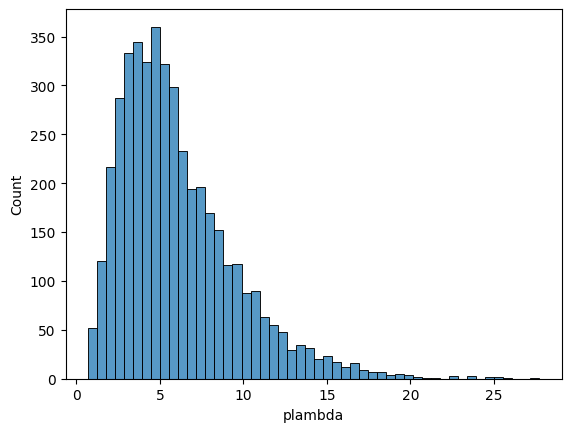

In [24]:
df_p['plambda'] = poisson.mu
sns.histplot(data=df_p, x="plambda", bins=50)

In [25]:
y= df_p['Failure_today']

aux=((y-poisson.mu)**2-poisson.mu)/poisson.mu
auxr=sm.OLS(aux,poisson.mu).fit()
print(auxr.summary())

                                 OLS Regression Results                                
Dep. Variable:          Failure_today   R-squared (uncentered):                   0.001
Model:                            OLS   Adj. R-squared (uncentered):              0.001
Method:                 Least Squares   F-statistic:                              6.226
Date:              vie., 25 abr. 2025   Prob (F-statistic):                      0.0126
Time:                        00:27:48   Log-Likelihood:                         -8281.8
No. Observations:                4413   AIC:                                  1.657e+04
Df Residuals:                    4412   BIC:                                  1.657e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [26]:
alpha=np.exp(0.0085)
print(alpha)

1.0085362275720395


## 8. Modelo Binomial Negativa

Se estimó el modelo de regresión Binomial Negativa para explicar el número de fallas mensuales. Este modelo permite una mayor flexibilidad al ajustar para la sobredispersión detectada en los datos. Se usaron las mismas variables explicativas que en el modelo Poisson. Sus coeficientes se interpretan de forma similar, pero con errores estándar corregidos por dispersión.

El modelo muestra un ajuste considerablemente más robusto en comparación con modelos anteriores, especialmente teniendo en cuenta que la variable dependiente Failure_today es discreta y dispersa. La elección de este modelo es acertada para abordar conteos de eventos raros o con alta varianza, como las fallas en sensores, y sus resultados reflejan una mejora notable en la capacidad explicativa del modelo.

El valor del pseudo R² de 0.2539 (Cox-Snell) indica que el modelo logra capturar aproximadamente un 25% de la variabilidad en la variable dependiente, lo que es significativo en contextos de modelación de fallos, donde los eventos suelen ser esporádicos. Además, el log-likelihood (-12080) y la devianza (1239.6) sugieren un buen ajuste del modelo a los datos.

En cuanto a los coeficientes, se observa que varias ubicaciones (Location) presentan efectos estadísticamente significativos. Por ejemplo, las ubicaciones 14, 16, 17, 24, 27, 28, 40, 44 y 48 tienen coeficientes negativos y altamente significativos, lo cual sugiere que, en comparación con la ubicación base (probablemente Location 1 o la menor numerada), estas ubicaciones reducen la probabilidad de fallas. Esta información puede ser clave para identificar condiciones operativas o ambientales más favorables.

Por otra parte, variables climáticas y técnicas como Max_Temp, Min_Temp, Parameter1_Speed, Parameter4_9am y Parameter4_3pm también son significativas y coherentes con el fenómeno modelado. Por ejemplo, un aumento en la velocidad del parámetro 1 y en la temperatura mínima se asocian con mayores probabilidades de fallas, mientras que temperaturas máximas más altas y ciertos parámetros a las 3pm se vinculan con una disminución en la probabilidad de fallos, posiblemente reflejando condiciones térmicas más estables o sistemas menos exigidos.



In [27]:
negativebinomial = smf.glm(formula='Failure_today ~ C(Location)+Max_Temp+Min_Temp+Parameter1_Speed+Parameter3_9am+Parameter3_3pm+Parameter4_9am+Parameter4_3pm',
                            data=df_p,
                            family=sm.families.NegativeBinomial()).fit()

print(negativebinomial.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:          Failure_today   No. Observations:                 4413
Model:                            GLM   Df Residuals:                     4359
Model Family:        NegativeBinomial   Df Model:                           53
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -12080.
Date:              vie., 25 abr. 2025   Deviance:                       1239.6
Time:                        00:27:48   Pearson chi2:                     867.
No. Iterations:                     9   Pseudo R-squ. (CS):             0.2539
Covariance Type:            nonrobust                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -1.3042      0.48

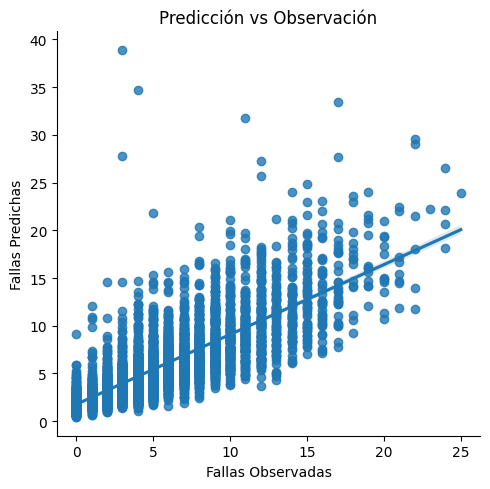

In [28]:
df_p['ypred']=negativebinomial.predict(df_p)

sns.lmplot(data=df_p, x='Failure_today', y='ypred')
plt.title('Predicción vs Observación')
plt.xlabel('Fallas Observadas')
plt.ylabel('Fallas Predichas')
plt.tight_layout()
plt.show()

## 9. Comparación de modelos de conteo (6, 7 y 8)

La comparación entre Poisson y Binomial Negativa muestra que esta última ofrece un mejor ajuste al capturar adecuadamente la varianza de los datos. Al igual que en los modelos anteriores, las variables climáticas (Min_Temp, Max_Temp) y parámetros de sensores resultaron significativas y robustas en ambas especificaciones. Se concluye que el modelo Binomial Negativa es más adecuado dada la evidencia de sobredispersión.

El modelo de regresión de Binomial Negativa utilizado para modelar la probabilidad de fallas diarias (Failure_today) se ajusta de forma adecuada al contexto del problema, ya que esta técnica es especialmente útil en presencia de conteos de eventos raros y sobredispersión —es decir, cuando la varianza de la variable dependiente es mayor que su media, lo que es común en fallas técnicas poco frecuentes.

Los resultados obtenidos evidencian que el modelo logra capturar patrones significativos en los datos. Con un pseudo R² de 0.2539, se estima que cerca del 25% de la variabilidad observada en las fallas puede explicarse por las variables independientes incluidas en el modelo. Esta cifra es destacable dentro del contexto de modelos de conteo, donde generalmente es difícil obtener valores de R² altos.

En cuanto a las variables incluidas, tanto las características técnicas como ambientales mostraron ser relevantes. Por ejemplo:

Un mayor valor en la variable Parameter1_Speed se asocia con un incremento en la probabilidad de falla, con un coeficiente positivo y altamente significativo.

De forma similar, Min_Temp también incrementa el riesgo de falla, lo cual podría sugerir que temperaturas más altas durante la noche o madrugada podrían estar afectando la recuperación o estabilidad de los sistemas.

En contraste, Max_Temp y los parámetros técnicos medidos en la tarde (Parameter3_3pm, Parameter4_3pm) presentan coeficientes negativos, indicando que ciertas condiciones climáticas o cargas en la segunda mitad del día podrían estar asociadas con menor riesgo de falla, posiblemente por estabilización térmica o menor exigencia operativa.

Asimismo, el modelo permite identificar ubicaciones críticas, lo que es clave para el monitoreo geoespacial de los equipos. Por ejemplo, las ubicaciones 14, 16, 17, 24, 27, 28, 40, 44 y 48 presentan coeficientes negativos estadísticamente significativos, lo que indica que, en comparación con la categoría base, estas zonas tienen una menor incidencia de fallas. En particular, la ubicación 24 presenta un coeficiente de -1.26, lo que sugiere un efecto protector considerable. Este tipo de análisis puede ser útil para priorizar mantenimiento o planificar estrategias de redistribución de cargas.

Por otro lado, la significancia estadística de varios coeficientes, con valores p < 0.05, fortalece la validez del modelo. También se aprecia que la mayoría de las variables categóricas no son significativas, lo cual puede deberse a una baja incidencia de fallas en esas ubicaciones o a que el modelo ya está capturando la variabilidad mediante otras variables más informativas.

Como conclusión final al análisis, el modelo de regresión de Binomial Negativa no solo permite explicar parcialmente las condiciones asociadas a fallas, sino que también entrega información práctica para la gestión preventiva y la toma de decisiones operativas, destacando su utilidad como herramienta en el análisis de confiabilidad de sistemas. La interpretación de los coeficientes ayuda a entender cómo influyen los factores técnicos, climáticos y espaciales sobre la ocurrencia de fallas, y orienta hacia acciones concretas de mejora en infraestructura o mantenimiento.